In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
from PIL import Image
import numpy as np

In [3]:
import lzma
import pickle
with lzma.open("mnist.pkl.xz", 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [4]:
train_X, train_y = train_set
validation_X, validation_y = validation_set
test_X, test_y = test_set

In [5]:
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y)

[5 0 4 ..., 8 4 8]


## Q
看一下 mnist 資料

## 開始 Tensorflow

In [6]:
import tensorflow as tf
from tfdot import tfdot

## Softmax regression
基本上就是用
$ e ^ {W x +b} $ 的比例來計算機率 

其中 x 是長度 784 的向量（圖片）， W 是 10x784矩陣，加上一個長度為 10 的向量。 算出來的十個數值，依照比例當成我們預估的機率。

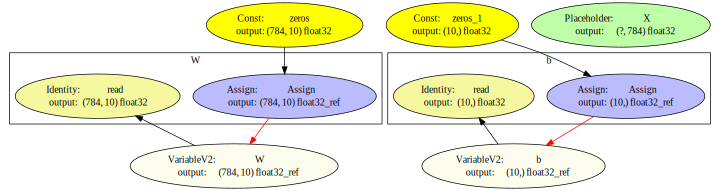

In [7]:
# 輸入的 placeholder
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
# 權重參數，為了計算方便和一些慣例（行向量及列向量的差異），矩陣乘法的方向和上面解說相反
W = tf.Variable(tf.zeros([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b') # 這裡可以看成是列向量

tfdot()

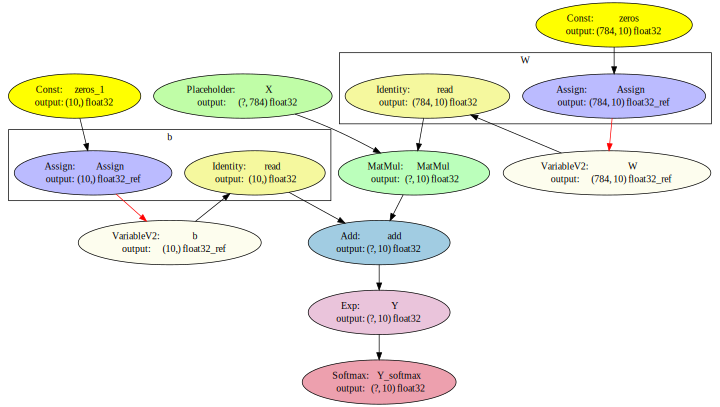

In [8]:
# 計算出來的公式
Y = tf.exp(tf.matmul(X, W) +b, name="Y")
Y_softmax = tf.nn.softmax(Y, name="Y_softmax")
# or 
#Y_softmax = tf.div(Y, tf.reduce_sum(Y, axis=1, keep_dims=True), name="Y_softmax")
tfdot()

Loss function 的計算是 cross_entorpy.

基本上就是 $-log(\Pr(Y_{true}))$

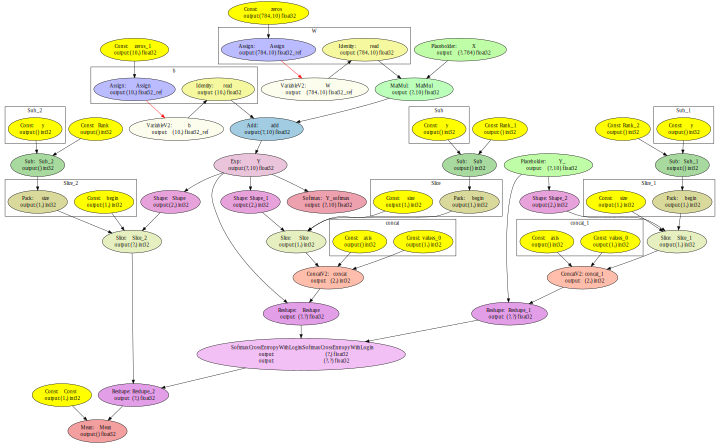

In [9]:
# 真正的 Y
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")
#和算出來的 Y 來做 cross entropy
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_*tf.log(Y_softmax), axis=1))
# or
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
tfdot()

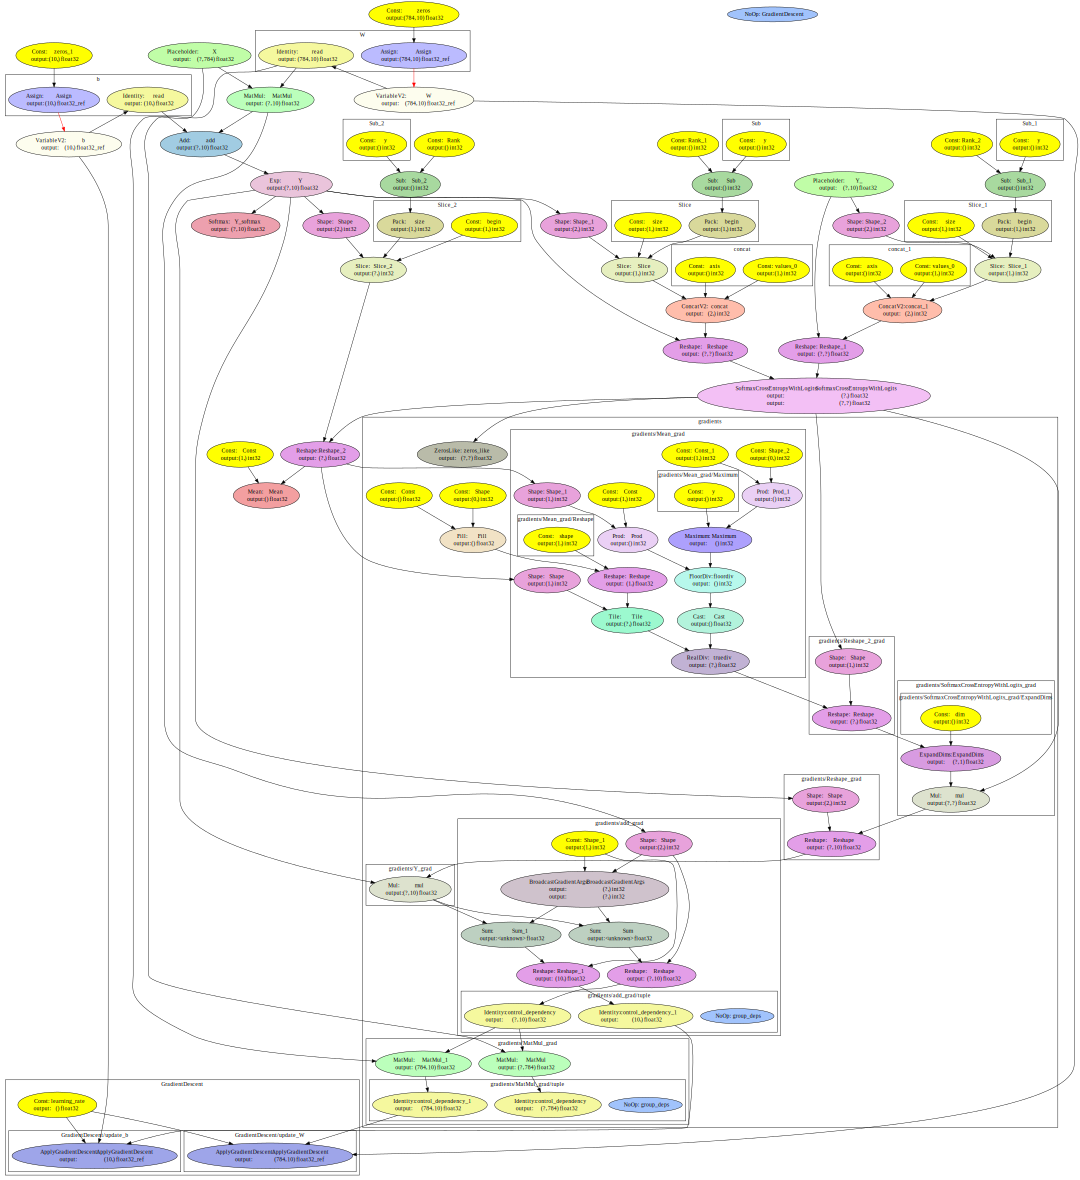

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

tfdot(size=(15,30))

In [11]:
train_Y = np.eye(10)[train_y]
test_Y = np.eye(10)[test_y]
validation_Y = np.eye(10)[validation_y]

In [12]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [13]:
for i in range(1000):
    rnd_idx = np.random.choice(train_X.shape[0], 50, replace=False)
    train_step.run(feed_dict={X: train_X[rnd_idx], Y_:train_Y[rnd_idx]})

In [14]:
Y.eval(feed_dict={X: train_X[:10]})

array([[  2.05432296,   0.74043328,   2.16859984,   5.40500736,
          0.76410401,   7.18076134,   1.90119195,   2.67315769,
          2.73921824,   2.1645031 ],
       [ 14.56563377,   0.27884921,   1.3517344 ,   1.74470973,
          0.61007762,   3.78315544,   1.69973707,   1.78306448,
          2.37228942,   1.3449645 ],
       [  0.83470976,   0.64771789,   1.58075094,   1.82165349,
          4.06564379,   0.94150674,   1.36361551,   1.2092253 ,
          1.18074286,   1.84615111],
       [  0.66669822,   8.6857481 ,   3.85801482,   2.35051942,
          1.19376111,   1.41960478,   1.35989177,   1.40059495,
          3.83610129,   1.251405  ],
       [  0.86289334,   1.72721052,   1.29284179,   1.41346967,
          8.10195541,   2.36564612,   1.77095735,   7.43428993,
          5.02493334,  12.07161522],
       [  1.60104561,   0.59325475,   6.46609259,   1.91014934,
          1.86941791,   2.1699729 ,   1.41341102,   2.32806396,
          3.61796355,   4.48581171],
       [  

In [15]:
prediction = tf.argmax(Y, axis=1)

# print predictions
prediction.eval(feed_dict={X: train_X[:10]})

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [16]:
# print labels
showX(train_X[:10])
train_y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [17]:
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_, 1))

correct_prediction.eval({X: train_X[:10] , Y_: train_Y[:10]})

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [18]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

accuracy.eval(feed_dict={X: train_X[:10] , Y_: train_Y[:10]})

1.0

In [19]:
accuracy.eval(feed_dict={X: train_X , Y_: train_Y})

0.90737998

In [20]:
# 合在一起來看
for t in range(10):
    for i in range(1000):
        rnd_idx = np.random.choice(train_X.shape[0], 200, replace=False)
        train_step.run(feed_dict={X: train_X[rnd_idx], Y_:train_Y[rnd_idx]})
    a = accuracy.eval({X: validation_X , Y_: validation_Y})
    print (t, a)

0 0.9229
1 0.9251
2 0.9277
3 0.9282
4 0.9287
5 0.9293
6 0.9304
7 0.931
8 0.9302
9 0.9296


In [21]:
accuracy.eval({X: test_X , Y_: test_Y})

0.92580003

In [22]:
sess.close()

# Multilayer Convolutional Network

In [23]:
# 重設 session 和 graph
tf.reset_default_graph()
# 輸入還是一樣
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")

In [24]:
# 設定 weight 和 bais
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name ='W')
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = 'b')

In [25]:
# 設定 cnn 的 layers
def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

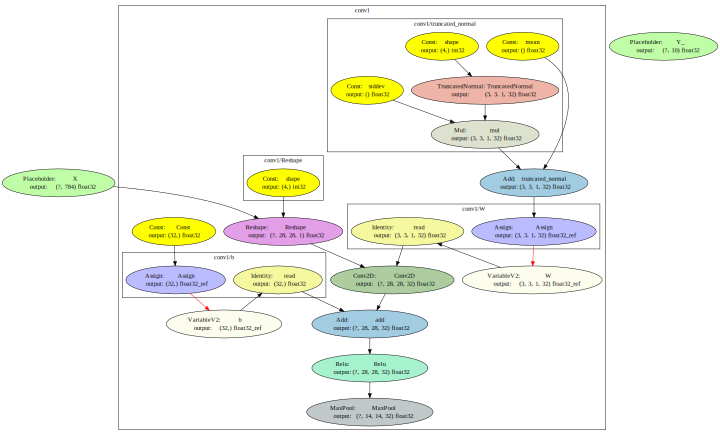

In [26]:
# fisrt layer
with tf.name_scope('conv1'):
    ## variables
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])
    ## build the layer
    X_image = tf.reshape(X, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(X_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

tfdot()

In [27]:
# second layer
with tf.name_scope('conv2'):
    ## variables
    W_conv2 = weight_variable([3,3,32,64])
    b_conv2 = bias_variable([64])
    ## build the layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

In [28]:
# fully-connected layer
with tf.name_scope('full'):
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1)+b_fc1)

In [29]:
# Dropout:  A Simple Way to Prevent Neural Networks from Over fitting
# https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder("float", name="keep_prob")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout
with tf.name_scope('readout'):
    W_fc2 = weight_variable([1024,10])
    b_fc2 = bias_variable([10])
    Y = tf.matmul(h_fc1_drop, W_fc2)+b_fc2

In [30]:
cross_entropy =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(Y, 1, name="prediction")
correct_prediction = tf.equal(prediction, tf.argmax(Y_, 1), name="correction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [31]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [32]:
%%timeit -r 1 -n 1
for i in range(5000):
    rnd_idx = np.random.choice(train_X.shape[0], 50, replace=False)
    if i%250 == 0:
        validation_accuracy = accuracy.eval({
                X: validation_X[:200], Y_: validation_Y[:200], keep_prob: 1.0 })
        print("step %d, validation accuracy %g"%(i, validation_accuracy))
    train_step.run({X: train_X[rnd_idx], Y_: train_Y[rnd_idx], keep_prob: 0.5 })

step 0, validation accuracy 0.115
step 250, validation accuracy 0.91
step 500, validation accuracy 0.95
step 750, validation accuracy 0.955
step 1000, validation accuracy 0.96
step 1250, validation accuracy 0.975
step 1500, validation accuracy 0.97
step 1750, validation accuracy 0.97
step 2000, validation accuracy 0.985
step 2250, validation accuracy 0.99
step 2500, validation accuracy 0.985
step 2750, validation accuracy 0.995
step 3000, validation accuracy 0.99
step 3250, validation accuracy 0.99
step 3500, validation accuracy 0.99
step 3750, validation accuracy 0.985
step 4000, validation accuracy 0.995
step 4250, validation accuracy 0.985
step 4500, validation accuracy 1
step 4750, validation accuracy 0.99
1 loop, best of 1: 10min 18s per loop


In [33]:
np.mean([accuracy.eval({X: test_X[i:i+1000], 
                        Y_: test_Y[i:i+1000],
                                   keep_prob: 1.0}) 
        for i in range(0, test_X.shape[0], 1000)]
)

0.98540002

In [34]:
tf.train.write_graph(sess.graph_def, "./", "mnist_simple.pb", as_text=False)


'./mnist_simple.pb'